**Table of contents**<a id='toc0_'></a>    
- [从头手搓-简单线性回归](#toc1_)    
- [PyTorch简单线性回归](#toc2_)    
- [PyTorch lightning](#toc3_)    
- [调试](#toc4_)    
- [手搓简单RNN](#toc5_)    
- [RNN的训练预测正弦波](#toc6_)    
    - [datas](#toc6_1_1_)    
    - [LiMu采样](#toc6_1_2_)    
    - [PyTorch采样](#toc6_1_3_)    
    - [model](#toc6_1_4_)    
    - [train](#toc6_1_5_)    
    - [test](#toc6_1_6_)    
  - [visualization](#toc6_2_)    
- [Transformer训练预测正弦波](#toc7_)    
  - [datas](#toc7_1_)    
    - [limu](#toc7_1_1_)    
    - [Dataset](#toc7_1_2_)    
  - [Model](#toc7_2_)    
  - [Train](#toc7_3_)    
- [Seq2Seq进行翻译](#toc8_)    
    - [datas](#toc8_1_1_)    
    - [model](#toc8_1_2_)    
    - [train](#toc8_1_3_)    
- [Transformer进行Seq2Seq翻译任务](#toc9_)    
  - [datas](#toc9_1_)    
  - [model](#toc9_2_)    
  - [train](#toc9_3_)    
  - [test](#toc9_4_)    
- [BERT](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[从头手搓-简单线性回归](#toc0_)

In [ ]:
from tqdm.auto import tqdm 
import time

for i in tqdm(range(100), desc='Outer', position=0):
    for j in tqdm(range(10), desc='Inner', position=1, leave=False):
        time.sleep(0.1)

In [1]:
22.97 +55.12+8.48

86.57000000000001

In [3]:
18 / 134, 18/4051

(0.13432835820895522, 0.004443347321648976)

In [3]:
test = [
    [1, 2, 3],
    [4, 5, 6]
]
test, [j for i in test for j in i]

([[1, 2, 3], [4, 5, 6]], [1, 2, 3, 4, 5, 6])

In [ ]:
# synthsis some datas with preset weights and bias
# create datas

import torch

def synth_datas(
    w:torch.Tensor = torch.tensor([2, -3.4], dtype=torch.float32),
    b:torch.Tensor = torch.tensor(4.2, dtype=torch.float32), 
    data_nums:int = 100000
):
    X = torch.normal(mean=0, std=0.1, size=(data_nums, w.shape[0]))
    y = X @ w.reshape(-1, 1) + b + torch.normal(mean=0, std=0.01, size=(data_nums,1))
    return X, y  

features, labels = synth_datas()
features.shape, labels.shape

In [ ]:
# set datas to Datasets of PyTorch

from torch.utils import data 
import time

# datasets = data.TensorDataset(features, labels)

def iter_data(
    features:torch.tensor, 
    labels:torch.tensor, 
    batch_size:int = 100
):
    shuffle = torch.randperm(len(features)) # tensor

    for iter in range(0, len(features), batch_size):
        batch_shuffle = shuffle[iter:(iter+batch_size)]

        batch_features = features[batch_shuffle]

        batch_labels = labels[batch_shuffle]
        
        yield (batch_features, batch_labels)

start = time.time()
batch_size = 100
for iter in iter_data(features=features, labels=labels, batch_size=batch_size):
    X, y = iter
    X, y = X.to('cuda:0'), y.to('cuda:0')
    # print(X.shape, y.shape)
    # print(X,'\n',y)
    # break

stop = time.time()
print(f'The time (s) of loading datasets each epoch: {stop - start} s')
print(f'The time (s) of loading datasets each iter in a epoch: {(stop - start)/batch_size} s')

In [ ]:
# Define the network structure

import torch 
import matplotlib.pyplot as plt 

def net(weight, bias, features):
    y_hat = features @ weight + bias
    return y_hat

def loss_fn(y_hat, labels):
    loss = (y_hat - labels)**2 / 2
    return loss

def update_params(params, lr=0.001, batch_size=100):
    with torch.no_grad():
        for param in params:
            # param -= (lr * param.grad)/batch_size    # 数值变小，以防后续数值不稳定
            param -= lr*param.grad/batch_size
            param.grad.zero_()

batch_size = 100
epochs = 10

# initialize the weiht with normal
weight = torch.normal(mean=0, std=0.01, size=(2, 1), dtype=torch.float32, requires_grad=True, device='cuda:0')
print('weight = ', weight)
print('weight.shape = ', weight.shape)
bias = torch.normal(mean=0, std=0.01, size=(1,), dtype=torch.float32, requires_grad=True, device='cuda:0')
print('bias = ', bias)
print('bias.shape = ', bias.shape)

loss_in_epoch = []
loss_in_epochs = []
for epoch in range(epochs):
    for iter in iter_data(features=features, labels=labels, batch_size=100):
        X, y = iter
        X, y = X.to('cuda:0'), y.to('cuda:0')
        y_hat = net(features=X, weight=weight, bias=bias)
        loss = loss_fn(y_hat, y)
        loss.sum().backward()   # 必须是标量才能求导，loss.sum()变成标量
        update_params(params=[weight, bias], lr=0.1, batch_size=batch_size)
        # print(f'loss: {loss.detach().numpy()}')
        loss_in_epoch.append(loss.sum().detach())
    # print(loss_in_epoch)
    loss_mean_in_epoch = torch.mean(torch.tensor(loss_in_epoch))
    loss_in_epochs.append(loss_mean_in_epoch)
print('='*20)
print(f'Learned weight = {weight.shape}')
print(f'Learned weight = {weight}')
print(f'Learned bias = {bias.shape}')
print(f'Learned bias = {bias}')

plt.figure()
plt.plot(loss_in_epochs)

# <a id='toc2_'></a>[PyTorch简单线性回归](#toc0_)

In [ ]:
import torch 

def synth_datas(w, b, example_nums):
    X = torch.normal(mean=0, std=0.1, size=(example_nums, w.shape[0]), dtype=torch.float32)
    y = X@w + b
    y += torch.normal(mean=0, std=0.1, size=y.shape, dtype=torch.float32)
    return X, y 

w = torch.tensor([2, -3.4], dtype=torch.float32).reshape(2, 1)  # 注意形状 (shape)
b = torch.tensor([4.2], dtype=torch.float32)
features, labels = synth_datas(w=w, b=b, example_nums=10000)
features.shape, labels.shape

In [ ]:
from torch.utils import data 
import time 
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

datasets = data.TensorDataset(features, labels)
iter_datasets = data.DataLoader(
    dataset = datasets, 
    shuffle = True, 
    batch_size = 100, 
    num_workers = 10
)

# net = nn.Sequential(nn.Linear(2, 1)).to('cuda:0')
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, X):
        return self.linear(X)

net = Net()
net = net.to('cuda:0')

loss_fn = nn.MSELoss()
optimer = optim.SGD(net.parameters(), lr=0.1)

start = time.time()
epochs = 100
loss_epochs = []
for epoch in range(epochs):
    losses_in_a_epoch = []
    for iter in iter_datasets:
        X, y = iter
        X, y = X.to('cuda:0'), y.to('cuda:0')
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        optimer.zero_grad()
        loss.backward()
        optimer.step()
        losses_in_a_epoch.append(loss.detach())
    loss_mean = torch.mean(torch.tensor(losses_in_a_epoch))
    print(f'{epoch+1}/{epochs}', 'loss=', loss_mean, sep='\t')
    loss_epochs.append(loss_mean)
# print(f'learned_weight: {net[0].weight.data}')
# print(f'learned_bias: {net[0].bias.data}')
print(f'learned_weight: {net.linear.weight.data}')
print(f'learned_bias: {net.linear.bias.data}')
plt.figure()
plt.plot(loss_epochs)
plt.xlabel('epochs')
plt.ylabel('loss')
stop = time.time()
print(f'Total time: {stop - start} s.')

# <a id='toc3_'></a>[PyTorch lightning](#toc0_)

- 官方教程：[https://lightning.ai/docs/pytorch/stable/expertise_levels.html](https://lightning.ai/docs/pytorch/stable/expertise_levels.html)

In [ ]:
# synthsis some datas with preset weights and bias
# create datas

import torch


def synth_datas(
    w:torch.Tensor = torch.tensor([2, -3.4], dtype=torch.float32),
    b:torch.Tensor = torch.tensor(4.2, dtype=torch.float32), 
    data_nums:int = 100000
):
    X = torch.normal(mean=0, std=0.1, size=(data_nums, w.shape[0]))
    y = X @ w.reshape(-1, 1) + b + torch.normal(mean=0, std=0.01, size=(data_nums,1))
    return X, y  

features, labels = synth_datas()
features.shape, labels.shape

In [ ]:
import torch 
from torch.utils import data
from torch import nn, optim
import lightning as L

######################################################
# 1. Datasets module (data.py)
######################################################
datasets = data.TensorDataset(features, labels)
iter_datasets = data.DataLoader(dataset=datasets, shuffle=True, batch_size=128, num_workers=10)

######################################################
# 2. Define the network structure (network.py)
######################################################
# Pre-define the network structure via torch.nn.Module
class AlphaFold2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(2, 1))

    def forward(self, X):
        return self.linear(X)

######################################################
# 3. PyTorch lightning structure (lightningNetwork.py)
######################################################
class LNet(L.LightningModule):
    def __init__(self, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.model = AlphaFold2()                       # Init the network
        self.loss_fn = nn.MSELoss()                     # Init the loss function

    def forward(self, X):   # Forward
        return self.model(X)

    def training_step(self, batch, batch_idx):
        X, y = batch 
        y_hat = self.forward(X)
        loss = self.loss_fn(y_hat, y)             # cal. loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01)   # Define optimizer
        return optimizer

    def validation_step(self, batch, batch_idx):
        X, y = batch 
        y_hat = self.forward(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        X, y = batch 
        y_hat = self.forward(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        X, _ = batch 
        y_hat = self.forward(X)
        return y_hat

######################################################
# 3. init the net and start training (main.py)
######################################################
autoNet = LNet()
trainer = L.Trainer(
    # default_root_dir="./lightning_logs", # saves checkpoints to './lightning_logs' at every epoch end
    limit_train_batches=1, 
    max_epochs=5, 
    devices=1, 
    accelerator="gpu", 
    # log_every_n_steps=1,
    # profiler="simple"
)

## training and validation
## 可以单独进行validation
trainer.fit(model=autoNet, train_dataloaders=iter_datasets, val_dataloaders=iter_datasets)
# trainer.validate(model=autoNet, dataloaders=iter_datasets)    

## The test set is NOT used during training, 
## it is ONLY used once the model has been trained to see how the model will do in the real-world.
# trainer.test(model=autoNet, dataloaders=iter_datasets)

## prediction
# trainer.predict(model=autoNet, dataloaders=iter_datasets)

In [ ]:
checkpoint = './lightning_logs/version_0/checkpoints/epoch=14-step=15.ckpt'
trained_model = LNet.load_from_checkpoint(checkpoint, map_location='cpu')

# disable randomness, dropout, etc...
trained_model.eval()
y_hat = trained_model(features)                 # map_location='cpu', run on cpu device
# y_hat = trained_model(features.to('cuda:0'))  # default mode trained on gpu, so copy 'features' to gpu, then predict
y_hat

# <a id='toc4_'></a>[调试](#toc0_)

# <a id='toc5_'></a>[手搓简单RNN](#toc0_)

In [ ]:
import torch 
from torch import nn 
from torch.nn import functional as F 


class SimpleRNN(nn.Module):
    def __init__(self,
                 vocab_size:int,
                 num_hiddens:int,
                 bidirectional:bool=False,
                 batch_size:int=2):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens 
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.rnn = nn.RNN(
            input_size=vocab_size,
            hidden_size=num_hiddens,
            num_layers=1,
            bidirectional=False,
            # batch_first=True
        )
        self.state = self.begin_state(batch_size=batch_size, num_hiddens=num_hiddens)

    def begin_state(self, batch_size:int, num_hiddens:int):
        return torch.zeros(1, batch_size, num_hiddens)
    
    def forward(self, X):
        X = F.one_hot(X.T.long(), self.vocab_size).type(torch.float32)
        y, new_state = self.rnn(X, self.state)
        return y, new_state
    

batch_size, num_steps = 2, 5

simple_rnn = SimpleRNN(vocab_size=10, num_hiddens=8, batch_size=2)
# simple_rnn.state.shape

input = torch.zeros(size=(batch_size, num_steps))
# input
# y, new_state = simple_rnn(X=input)
# y.shape, new_state.shape

simple_rnn(X=input)[0].shape

# <a id='toc6_'></a>[RNN的训练预测正弦波](#toc0_)

### <a id='toc6_1_1_'></a>[datas](#toc0_)

### <a id='toc6_1_2_'></a>[LiMu采样](#toc0_)

In [ ]:
import torch 
import matplotlib.pyplot as plt  


max_tokens = 100
features = torch.arange(0,max_tokens, step=0.01) 
labels = torch.sin(features) + torch.randn(len(features))*0.1
print(features.shape, labels.shape)


plt.figure()
plt.plot(features, labels)
plt.xlabel('features')
plt.ylabel('labels')
plt.title('sin(features) + noise')
plt.show()

In [ ]:
import random
import torch 


def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)   # 生成一个随机偏移量 offset，范围在 0 到 num_steps 之间。这样做的目的是为了随机化数据的起始位置，避免模型过于依赖数据的开始部分，提高泛化能力。
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size  # 计算可以形成完整批次的序列长度
    Xs = torch.tensor(corpus[offset: offset + num_tokens])  # 提取 X 序列
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])  # 提取 Y 序列
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)  # 重塑形状
    num_batches = Xs.shape[1] // num_steps  # 计算批次数
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y


for X,y in seq_data_iter_sequential(corpus=labels, batch_size=2, num_steps=50):
    print(X.shape, y.shape, sep='\n')
    break

In [ ]:
import random


def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


for X, y in seq_data_iter_random(corpus=list(labels.numpy()), batch_size=2, num_steps=50):
    print(X.shape, y.shape, sep='\n')
    break

### <a id='toc6_1_3_'></a>[PyTorch采样](#toc0_)

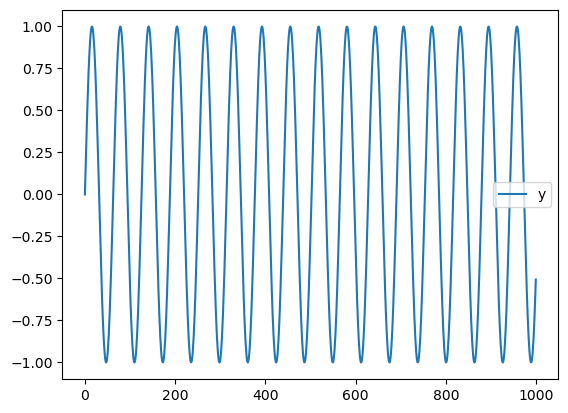

In [35]:
import torch 
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


# 数据集生成
class SineWaveDataset(Dataset):
    def __init__(self, seq_len=50, num_samples=1000):
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.data, self.features, self.labels = self._generate_data()

    def _generate_data(self):
        x = torch.linspace(0, 100, self.num_samples)
        y = torch.sin(x)
        # x = torch.arange(0, self.num_samples)
        # y = torch.sin(x)
        data = []
        for i in range(len(y) - self.seq_len):
            data.append((y[i:i + self.seq_len], y[i + 1:i + 1 + self.seq_len]))
        return (data, x, y)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    

datasets = SineWaveDataset(seq_len=5, num_samples=1000)
train_loader = DataLoader(datasets, batch_size=64, shuffle=True)

# for X, y in train_loader:
#     print(X.shape, y.shape, sep='\n')
#     # print(X, y, sep='\n')
#     plt.plot(X[0], label='X')
#     plt.plot(y[0], label='y')
#     plt.legend()
#     break

# plt.plot(datasets.features, datasets.labels, label='x, y')
plt.plot(datasets.labels, label='y')
plt.legend()

### <a id='toc6_1_4_'></a>[model](#toc0_)

In [36]:
import torch 
from torch import nn 


class LSTMModel(nn.Module):
    def __init__(self, vocab_size:int, num_hiddens:int, num_layers:int, batch_size:int):
        super().__init__()
        self.vocab_size = vocab_size 
        self.num_hiddens = num_hiddens 
        self.num_layers = num_layers 
        self.rnn = nn.LSTM(
            input_size=vocab_size,
            hidden_size=num_hiddens,
            num_layers=num_layers, 
            dropout = 0.1, 
            batch_first=True
        )

        # self.hidden_state, self.cell_state = self.begin_state(num_layers=num_layers, batch_size=batch_size, num_hiddens=num_hiddens)
        self.fc = nn.Linear(num_hiddens, vocab_size)

    def begin_state(self, num_layers:int, batch_size:int, num_hiddens:int):
        return (torch.zeros(size=(num_layers, batch_size, num_hiddens)),
                torch.zeros(size=(num_layers, batch_size, num_hiddens)))

    def forward(self, x, hiddens, scheduled_sampling=False):
        # out: (batch_size, num_steps, num_hiddens)
        # new_state: (num_layers, batch_size, num_hiddens)
        out, new_state = self.rnn(x, hiddens)
        # output: (batch_size, num_steps, vocab_size)
        output = self.fc(out)  # 初始 LSTM 输出到全连接层

        # 使用计划采样
        if scheduled_sampling:
            # x: (batch_size, num_steps, vocab_size)
            batch_size, num_steps, _ = x.size()
            mix_x = []
            # 将第一个时间步的输入作为预测的初始输入
            mix_x.append(x[:, 1, :])
            for t in range(1, num_steps): 
                choose_matrix = (torch.rand(batch_size, 1).to(x.device) < 0.5).float()
                input_t = choose_matrix * x[:, t, :] + (1 - choose_matrix) * output[:, t-1, :]
                mix_x.append(input_t)

            mix_x = torch.stack(mix_x, dim=1)

            scheduled_sampling_out, new_state = self.rnn(mix_x, new_state)
            scheduled_sampling_out = self.fc(scheduled_sampling_out)
            # 覆盖原先的output
            output = scheduled_sampling_out

        return output, new_state
    

# test
num_layers, batch_size, num_hiddens = 1, 2, 128
vocab_size = 1
num_steps = 5

lstm_model = LSTMModel(vocab_size=1, num_hiddens=num_hiddens, num_layers=num_layers, batch_size=batch_size)

input = torch.zeros(size=(batch_size, num_steps, vocab_size))

hidden = lstm_model.begin_state(num_layers=num_layers, batch_size=batch_size, num_hiddens=num_hiddens)
y_hat, hiddens = lstm_model(x=input, hiddens=hidden, scheduled_sampling=True)

y_hat.shape, hiddens[0].shape, hiddens[1].shape

/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


(torch.Size([2, 5, 1]), torch.Size([1, 2, 128]), torch.Size([1, 2, 128]))

### <a id='toc6_1_5_'></a>[train](#toc0_)

/tmp/ipykernel_906824/2753421936.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


0/20	loss=	tensor(0.2734)
10/20	loss=	tensor(0.0026)


Text(0.5, 1.0, 'loss in epochs')

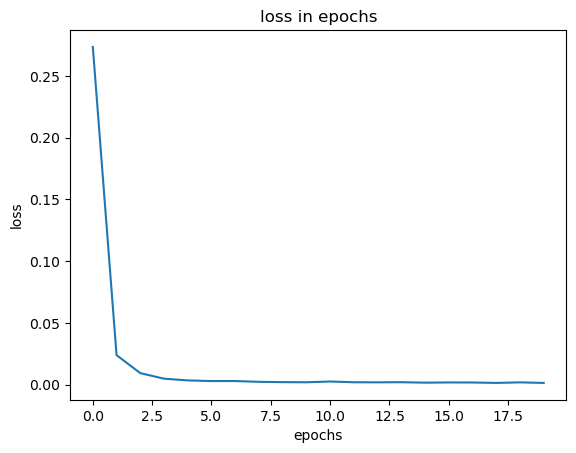

In [45]:
from torch import nn, optim 
from torch.nn import functional as F 


device = [torch.device('cuda:1')]

lr = 0.001
epochs = 20

num_layers, batch_size, num_hiddens = 4, 32, 512
num_steps, vocab_size = 50, 1

datasets = SineWaveDataset(seq_len=num_steps, num_samples=1000)
train_loader = DataLoader(datasets, batch_size=batch_size, shuffle=True, drop_last=True)

model = LSTMModel(vocab_size=vocab_size, num_hiddens=num_hiddens, num_layers=num_layers, batch_size=True).to(device[0])

# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimer = optim.Adam(model.parameters(), lr=lr)
# optimer = optim.SGD(model.parameters(), lr=lr)


loss_in_epochs = []
for epoch in range(epochs):   
    loss_in_epoch = []
    hiddens = model.begin_state(num_layers=num_layers, batch_size=batch_size, num_hiddens=num_hiddens)
    hiddens = (hiddens[0].to(device[0]), hiddens[1].to(device[0]))
    # for X, y in seq_data_iter_sequential(corpus=features, batch_size=batch_size, num_steps=num_steps):
    # for X, y in seq_data_iter_random(corpus=list(labels.numpy()), batch_size=batch_size, num_steps=num_steps):
    for X, y in train_loader:
        # 将数据reshape为(batch_size, num_steps, vocab_size)
        X = X.reshape(batch_size, num_steps, vocab_size).to(device[0])
        y = y.reshape(batch_size, num_steps, vocab_size).to(device[0])
        # 进行scheduled sampling
        y_hat, hiddens = model(x=X, hiddens=hiddens, scheduled_sampling=True)
        # y_hat, hiddens = model(x=X, hiddens=hiddens, scheduled_sampling=False)
        hiddens = (hiddens[0].detach(), hiddens[1].detach())
        
        l = loss_fn(y_hat, y)
        optimer.zero_grad()
        l.backward()
        # 防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimer.step()
        loss_in_epoch.append(l.detach())
    loss_mean = torch.mean(torch.tensor(loss_in_epoch))
    loss_in_epochs.append(loss_mean)
    if epoch % 10 == 0:
        print(f'{epoch}/{epochs}', 'loss=', loss_mean, sep='\t')


plt.figure()
plt.plot(loss_in_epochs)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss in epochs')

### <a id='toc6_1_6_'></a>[test](#toc0_)

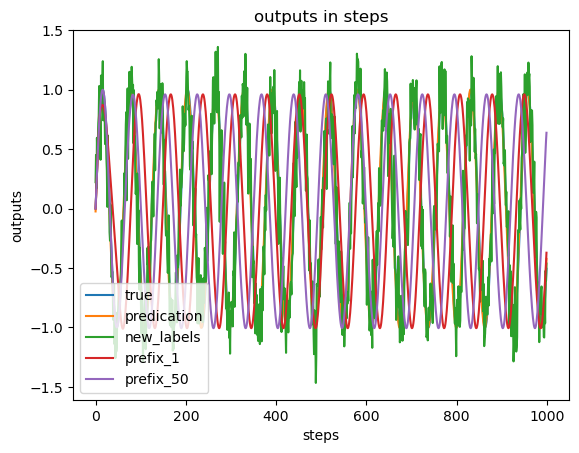

In [53]:
labels = datasets.labels

batch_size = 1

model.eval()
with torch.no_grad():
    # ----------------------
    # 1. 无warm-up, num_steps=1, 直接预测
    # ----------------------
    # 初始化隐藏状态和细胞状态
    hiddens = model.begin_state(num_layers=num_layers, batch_size=batch_size, num_hiddens=num_hiddens)
    hiddens = tuple(hidden.to(device[0]) for hidden in hiddens)

    # 单独取labels中的每一个数值进行预测：batch_size=1, num_steps=1
    outputs = []
    for i in range(len(labels)):
        # input: (batch_size, num_steps, vocab_size)
        # 将input reshape为(batch_size, 1, vocab_size) = (1, 1, 1)
        y_hat, hiddens = model(
            labels[i].reshape(batch_size, -1, vocab_size).to(device[0]), 
            hiddens
        )
        # y_hat: (batch_size, num_steps, vocab_size) = (1, 1, 1)
        outputs.append(y_hat.item())

    # ----------------------
    # 2. 无warm-up, num_steps=1, 合成新的输入new labels
    # ----------------------
    # 初始化隐藏状态和细胞状态
    hiddens = model.begin_state(num_layers=num_layers, batch_size=batch_size, num_hiddens=num_hiddens)
    hiddens = tuple(hidden.to(device[0]) for hidden in hiddens)

    # 单独取labels中的每一个数值进行预测：batch_size=1, num_steps=1
    new_max_tokens = 100
    new_features = torch.arange(0,new_max_tokens, step=0.1) 
    new_labels = torch.sin(new_features) + torch.randn(len(new_features))*0.2
    outputs_new_labels = []
    for i in range(len(new_labels)):
        # input: (batch_size, num_steps, vocab_size)
        # 将input reshape为(batch_size, 1, vocab_size) = (1, 1, 1)
        y_hat, hiddens = model(
            new_labels[i].reshape(batch_size, -1, vocab_size).to(device[0]), 
            hiddens
        )
        # y_hat: (batch_size, num_steps, vocab_size) = (1, 1, 1)
        outputs_new_labels.append(y_hat.item())
        

    # ----------------------
    # 3.先进行warm-up, num_steps=1, 以输入经过rnn计算后的结果作为输入，会导致误差累积
    # ----------------------
    # 重新初始化隐藏状态和细胞状态
    hiddens = model.begin_state(num_layers=num_layers, batch_size=batch_size, num_hiddens=num_hiddens)
    hiddens = tuple(hidden.to(device[0]) for hidden in hiddens)
    
    prefix_num = 10
    outputs_prefix = []
    outputs_prefix.append(labels[0].item())
    # 用真实数据进行warm-up
    for y in labels[1:prefix_num]:
        _, hiddens = model(
            torch.tensor(outputs_prefix[-1]).reshape(batch_size, -1, vocab_size).to(device[0]), 
            hiddens
        )
        outputs_prefix.append(y.item())
        
    # predict the rest, hiddens已经过 warm up 了
    for _ in range(len(labels[prefix_num:])):
        y_hat, hiddens = model(
            torch.tensor(outputs_prefix[-1]).reshape(batch_size, -1, vocab_size).to(device[0]), 
            hiddens
        )
        outputs_prefix.append(y_hat.item())


    # ----------------------
    # 4. 先进行warm-up, num_steps=50，以输入经过rnn计算后的结果作为输入，会导致误差累积
    # ----------------------
    # 重新初始化隐藏状态和细胞状态
    hiddens = model.begin_state(num_layers=num_layers, batch_size=batch_size, num_hiddens=num_hiddens)
    hiddens = tuple(hidden.to(device[0]) for hidden in hiddens)
    
    num_steps = 50
    prefix_num = 50
    outputs_prefix_50 = list(labels[0: num_steps].cpu().numpy())
    # warm-up
    _, hiddens = model(
        torch.tensor(outputs_prefix_50[-50:]).reshape(batch_size, num_steps, vocab_size).to(device[0]), 
        hiddens
    )

    # predict the rest, hiddens已经过warm up了
    for _ in range(len(labels[prefix_num:])):
        y_hat, hiddens = model(
            torch.tensor(outputs_prefix_50[-50:]).reshape(batch_size, num_steps, vocab_size).to(device[0]), 
            hiddens 
        )
        # y_hat: (batch_size, num_steps, vocab_size) = (1, 50, 1)
        # print(y_hat[0, -1].detach().cpu().numpy()[0])
        outputs_prefix_50.append(y_hat[0, -1].detach().cpu().numpy()[0])



metrics = {
    'true': list(labels.numpy()),
    'predication': outputs, 
    'new_labels': outputs_new_labels,
    'prefix_1': outputs_prefix,
    'prefix_50': outputs_prefix_50
}


def plot_outputs(outputs, start_point=0, length=1000):
    # ----------------------
    # 绘制结果
    # ----------------------    
    # plt.figure(figsize=(10, 5))
    for key, value in outputs.items():
        plt.plot(value[start_point:length], label=key)
    plt.xlabel('steps')
    plt.ylabel('outputs')
    plt.legend()
    plt.title('outputs in steps')
    

plot_outputs(metrics, start_point=0, length=1000)

## <a id='toc6_2_'></a>[visualization](#toc0_)

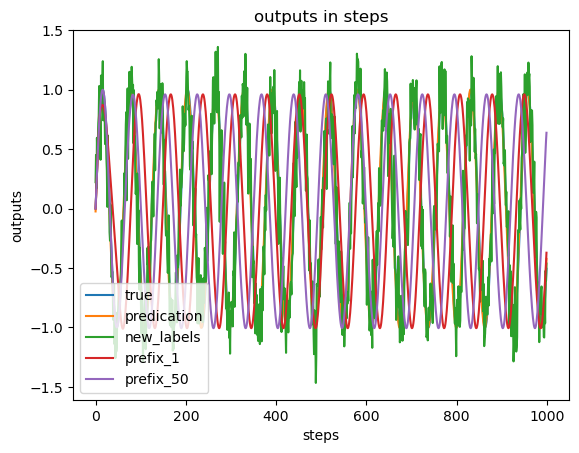

In [54]:
plot_outputs(metrics, start_point=0, length=2000)

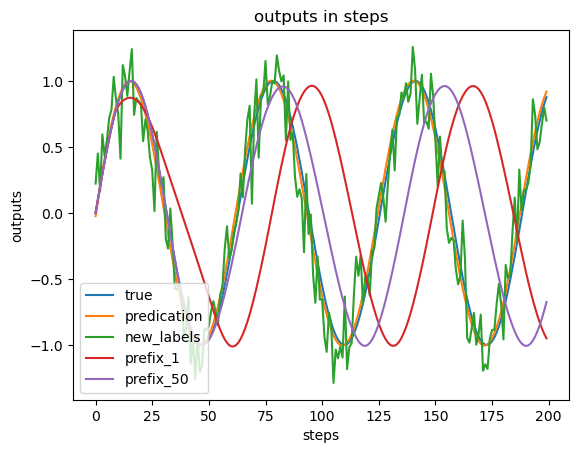

In [55]:
plot_outputs(metrics, start_point=0, length=200)

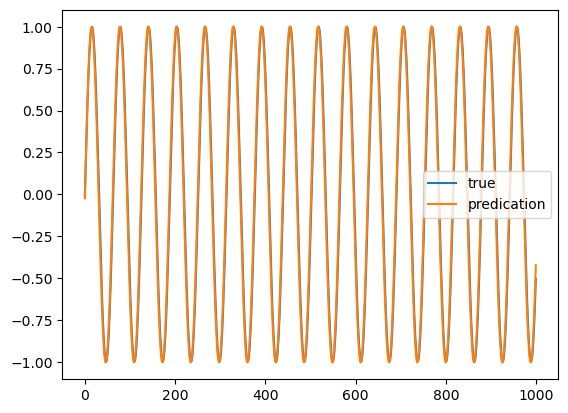

In [60]:
plt.plot(metrics['true'], label='true')
plt.plot(metrics['predication'], label='predication')
# plt.plot(metrics['prefix_1'], label='prefix_1')
# plt.plot(metrics['prefix_50'], label='prefix_50')
plt.legend()

# <a id='toc7_'></a>[Transformer训练预测正弦波](#toc0_)

## <a id='toc7_1_'></a>[datas](#toc0_)

### <a id='toc7_1_1_'></a>[limu](#toc0_)

torch.Size([1000]) torch.Size([1000])


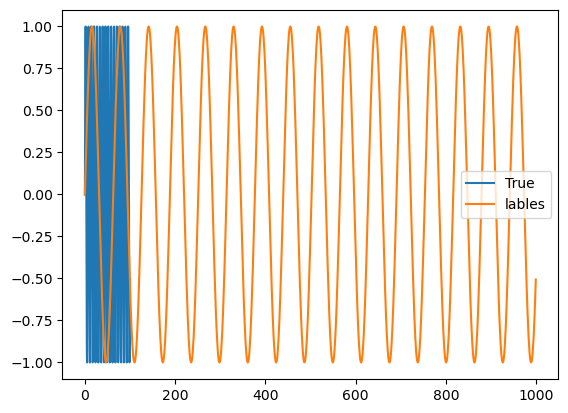

In [62]:
import torch 
import matplotlib.pyplot as plt 


seq_length = 1000
features = torch.linspace(0, 100, seq_length)
labels = torch.sin(features)
print(features.shape, labels.shape)

plt.plot(features, labels, label='True')
plt.plot(labels, label='lables')
plt.legend()


import random
import matplotlib.pyplot as plt 


def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


# for X, y in seq_data_iter_random(corpus=list(labels.numpy()), batch_size=2, num_steps=5):
#     print(X.shape, y.shape, sep='\n')
#     print(X, y, sep='\n')
#     plt.plot(X[0], label='X')
#     plt.plot(y[0], label='y')
#     plt.legend()
#     break

torch.Size([18, 50])
torch.Size([18, 50])


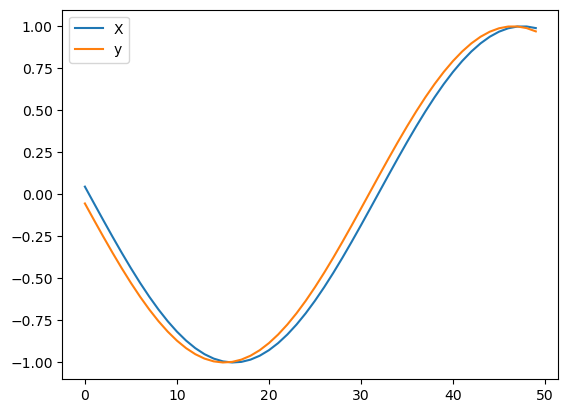

In [99]:
import torch 
from torch.utils import data 

class GetData(data.Dataset):
    def __init__(self, corpus:list, num_steps:int):
        self.data = self._seq_data_iter_random(corpus=corpus, num_steps=num_steps)

    def _seq_data_iter_random(self, corpus, num_steps):  
        """使用随机抽样生成一个小批量子序列"""
        datas = []
        # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
        start_position = random.randint(0, num_steps - 1)
        corpus = corpus[start_position:]
        num_subseqs = len(corpus) // num_steps       

        for i in range(0, (num_subseqs-1) * num_steps, num_steps):
            # 在这里，initial_indices包含子序列的随机起始索引
            x = torch.tensor(corpus[i: i + num_steps], dtype=torch.float32)
            y = torch.tensor(corpus[i + 1: i + 1 + num_steps], dtype=torch.float32)           
            datas.append((x, y))

        return datas

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    

datasets = GetData(corpus=list(labels.numpy()), num_steps=50)

train_loader = DataLoader(datasets, batch_size=64, shuffle=True)

for X, y in train_loader:
    print(X.shape, y.shape, sep='\n')
    plt.plot(X[0], label='X')
    plt.plot(y[0], label='y')
    plt.legend()
    break


### <a id='toc7_1_2_'></a>[Dataset](#toc0_)

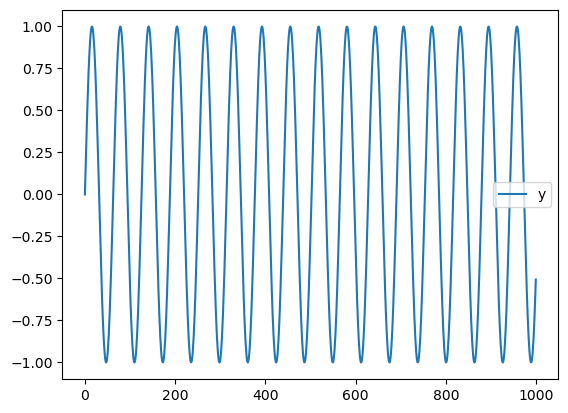

In [32]:
import torch 
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


# 数据集生成
class SineWaveDataset(Dataset):
    def __init__(self, seq_len=50, num_samples=1000):
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.data, self.features, self.labels = self._generate_data()

    def _generate_data(self):
        x = torch.linspace(0, 100, self.num_samples)
        y = torch.sin(x)
        # x = torch.arange(0, self.num_samples)
        # y = torch.sin(x)
        data = []
        for i in range(len(y) - self.seq_len):
            data.append((y[i:i + self.seq_len], y[i + 1:i + 1 + self.seq_len]))
        return (data, x, y)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    

datasets = SineWaveDataset(seq_len=5, num_samples=1000)
train_loader = DataLoader(datasets, batch_size=64, shuffle=True)

# for X, y in train_loader:
#     print(X.shape, y.shape, sep='\n')
#     # print(X, y, sep='\n')
#     plt.plot(X[0], label='X')
#     plt.plot(y[0], label='y')
#     plt.legend()
#     break

# plt.plot(datasets.features, datasets.labels, label='x, y')
plt.plot(datasets.labels, label='y')
plt.legend()

## <a id='toc7_2_'></a>[Model](#toc0_)

## <a id='toc7_3_'></a>[Train](#toc0_)

/tmp/ipykernel_906824/2753421936.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Epoch 0, Loss: 1.2588730732599893
Epoch 10, Loss: 0.009366498825450738


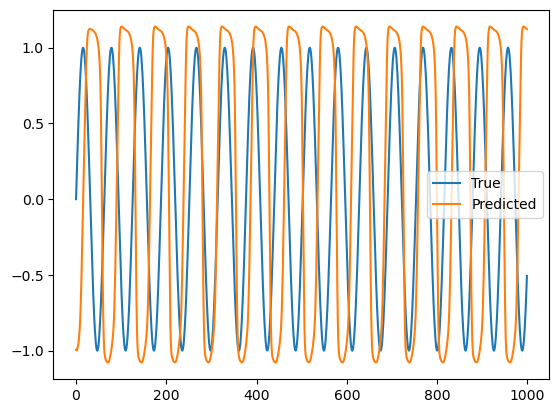

In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


# 位置编码函数
def positional_encoding(seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)


# Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(1, d_model)
        self.positional_encoding = positional_encoding(seq_len, d_model).to(torch.float32)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, src, tgt):
        src = self.input_layer(src.unsqueeze(-1)) + self.positional_encoding.to(src.device)
        tgt = self.input_layer(tgt.unsqueeze(-1)) + self.positional_encoding.to(tgt.device)
        output = self.transformer(src, tgt)
        output = self.output_layer(output).squeeze(-1)
        return output


# 检查设备和多 GPU 支持
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datasets = SineWaveDataset(seq_len=50, num_samples=1000)
train_loader = DataLoader(datasets, batch_size=64, shuffle=True)
# 模型、损失和优化器
model = TransformerModel(seq_len=50)

model = nn.DataParallel(model).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 训练
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    counter = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        # print(src.shape, tgt.shape)
        optimizer.zero_grad()
        output = model(src, src)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        counter += 1

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / counter}")


# 测试
model.eval()
length = 50
# test_data = labels[:length].reshape(1, length).to(device)
test_data = datasets[0][0].unsqueeze(0).to(device)
predictions = []
with torch.no_grad():
    for _ in range(1000):
        prediction = model(test_data, test_data)
        # print(prediction.shape)
        prediction = prediction[:, -1]
        predictions.append(prediction.item())
        test_data = torch.cat([test_data[:, 1:], prediction.unsqueeze(0)], dim=1)


# 可视化
plt.plot(datasets.labels, label='True')
plt.plot(predictions, label='Predicted')
plt.legend()

# <a id='toc8_'></a>[Seq2Seq进行翻译](#toc0_)

### <a id='toc8_1_1_'></a>[datas](#toc0_)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re

# 加载数据
def load_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    pairs = [line.strip().split("\t") for line in lines if len(line.strip().split("\t")) == 2]
    return zip(*pairs)

english_sentences, french_sentences = load_data("./data/fra-eng/fra.txt")

# 数据预处理
def build_vocab(sentences):
    processed_sentences = [re.sub(r'[^\w\s]', '', sentence) for sentence in sentences]
    vocab = {word: idx for idx, word in enumerate(set(" ".join(processed_sentences).split()))}
    vocab["<pad>"] = len(vocab)
    vocab["<sos>"] = len(vocab)
    vocab["<eos>"] = len(vocab)
    return vocab

def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab["<pad>"]) for word in sentence.split()] + [vocab["<eos>"]]

def pad_sequence(sequence, max_len, pad_idx):
    return sequence + [pad_idx] * (max_len - len(sequence))

def collate_fn(batch):
    src_sentences, tgt_sentences = zip(*batch)
    src_lengths = [len(seq) for seq in src_sentences]
    tgt_lengths = [len(seq) for seq in tgt_sentences]
    max_src_len = max(src_lengths)
    max_tgt_len = max(tgt_lengths)

    padded_src = [pad_sequence(list(seq), max_src_len, en_vocab["<pad>"]) for seq in src_sentences]
    padded_tgt = [pad_sequence(list(seq), max_tgt_len, fr_vocab["<pad>"]) for seq in tgt_sentences]

    return torch.tensor(padded_src), torch.tensor(padded_tgt)

en_vocab = build_vocab(english_sentences)
fr_vocab = build_vocab(french_sentences)

# 数据集定义
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = [sentence_to_indices(s, src_vocab) for s in src_sentences]
        self.tgt_sentences = [sentence_to_indices(s, tgt_vocab) for s in tgt_sentences]

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.src_sentences[idx]), torch.tensor(self.tgt_sentences[idx])

# 模型定义
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, bidirectional=True, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hid_dim * 2 + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]
        hidden = hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = torch.sum(self.v * energy, dim=2)
        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hid_dim * 2 + emb_dim, dec_hid_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(enc_hid_dim * 2 + dec_hid_dim + emb_dim, output_dim)
        self.attention = attention

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)
        a = self.attention(hidden[-1].unsqueeze(0), encoder_outputs)
        weighted = torch.bmm(a.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.contiguous())
        prediction = self.fc_out(torch.cat((output.squeeze(1), weighted.squeeze(1), embedded.squeeze(1)), dim=1))
        return prediction, hidden

# 超参数定义
SRC_VOCAB_SIZE = len(en_vocab)
TGT_VOCAB_SIZE = len(fr_vocab)
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2

encoder = Encoder(SRC_VOCAB_SIZE, EMB_DIM, HID_DIM, N_LAYERS).cuda()
attention = Attention(HID_DIM, HID_DIM).cuda()
decoder = Decoder(TGT_VOCAB_SIZE, EMB_DIM, HID_DIM, HID_DIM, N_LAYERS, attention).cuda()

# 数据并行
device_ids = list(range(torch.cuda.device_count()))
encoder = nn.DataParallel(encoder, device_ids=device_ids)
decoder = nn.DataParallel(decoder, device_ids=device_ids)

# 数据加载
dataset = TranslationDataset(english_sentences, french_sentences, en_vocab, fr_vocab)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# 训练循环
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=fr_vocab["<pad>"])

for epoch in range(5):
    for src, tgt in dataloader:
        src, tgt = src.cuda(), tgt.cuda()
        optimizer.zero_grad()
        encoder_outputs, encoder_hidden = encoder(src)
        if isinstance(encoder_hidden, tuple):
            encoder_hidden = torch.cat([h for h in encoder_hidden], dim=0)
        decoder_hidden = encoder_hidden[:decoder.module.rnn.num_layers]
        decoder_input = torch.tensor([fr_vocab["<sos>"]] * src.size(0)).cuda()
        loss = 0
        for t in range(1, tgt.size(1)):
            output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(output, tgt[:, t])
            decoder_input = tgt[:, t]
        loss.backward()
        optimizer.step()

print("Training completed")


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py", line 83, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1068992/3958133569.py", line 97, in forward
    output, hidden = self.rnn(rnn_input, hidden.contiguous())
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/rnn.py", line 1137, in forward
    self.check_forward_args(input, hx, batch_sizes)
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/rnn.py", line 283, in check_forward_args
    self.check_hidden_size(hidden, expected_hidden_size)
  File "/bmp/backup/zhaosy/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/rnn.py", line 266, in check_hidden_size
    raise RuntimeError(msg.format(expected_hidden_size, list(hx.size())))
RuntimeError: Expected hidden size (2, 1, 512), got [1, 1, 512]


### <a id='toc8_1_2_'></a>[model](#toc0_)

### <a id='toc8_1_3_'></a>[train](#toc0_)

# <a id='toc9_'></a>[Transformer进行Seq2Seq翻译任务](#toc0_)

## <a id='toc9_1_'></a>[datas](#toc0_)

In [ ]:
import torch 
from torch.utils import data 


class ExampleDataset(data.Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]

    

## <a id='toc9_2_'></a>[model](#toc0_)

In [26]:
import torch 
from torch import nn 


class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

    def init_state(self, enc_outputs):
        return (enc_outputs, [[None] * self.decoder.num_layers] )

    def forward(self, src, tgt):
        enc_outputs = self.encoder(src)
        state = self.init_state(enc_outputs)
        dec_outputs = self.decoder(tgt, memory=state[0], memory_key_padding_mask=None)
        return dec_outputs, state


# Test 
d_model = 512 
nhead = 8
dim_feedforward = 2048 
dropout = 0.1
batch_first = True 
num_layers = 6

encoder = nn.TransformerEncoder(
    nn.TransformerEncoderLayer(
        d_model = d_model, 
        nhead = nhead, 
        dim_feedforward = dim_feedforward, 
        dropout = dropout, 
        batch_first = batch_first
    ), 
    num_layers = num_layers
)

decoder = nn.TransformerDecoder(
    nn.TransformerDecoderLayer(
        d_model = d_model, 
        nhead = nhead, 
        dim_feedforward = dim_feedforward, 
        dropout = dropout, 
        batch_first = batch_first
    ), 
    num_layers = num_layers
)

net = Seq2SeqModel(encoder, decoder)

batch_size = 2
src_seq_len = 20
tgt_seq_len = 20
vocab_size = 512

src = torch.ones(size=(batch_size, src_seq_len, vocab_size))
tgt = torch.ones(size=(batch_size, tgt_seq_len, vocab_size))

output, state = net(src, tgt)

output.shape, state[0].shape

(torch.Size([2, 20, 512]), torch.Size([2, 20, 512]))

## <a id='toc9_3_'></a>[train](#toc0_)

## <a id='toc9_4_'></a>[test](#toc0_)

In [4]:
import datasets




# <a id='toc10_'></a>[BERT](#toc0_)

In [ ]:
#@tab all
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """
    Get tokens of the BERT input sequence and their segment IDs.
    Args:
        tokens_a: List[str] 第一段文本的词元列表（即第一句话的分词结果）。
        tokens_b: List[str] （可选）第二段文本的词元列表（即第二句话的分词结果）。在单句任务中，此参数可以省略。
    Returns:
        tokens: List[str] 词元列表，其中第一个词元是'<cls>'，表示序列的开始，最后一个词元是'<sep>'，表示序列的结束。
        segments: List[int] 段标识列表，其中0表示第一段，1表示第二段。
    """
    # classification (cls) and separator (sep) tokens are added
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments


# 测试
tokens_a = ['You', 'are', 'the', 'best']
tokens_b = ['You', 'are', 'the', 'worst']

tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)

tokens, segments

In [3]:
from torch import nn 
import torch 
from d2l import torch as d2l


#@tab pytorch
#@save
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, max_len=1000, key_size=768, query_size=768, value_size=768, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            # 此处调用TransformerEncoder中的EncoderBlock
            self.blks.add_module(f"{i}", d2l.EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        # 此处用nn.Parameter来创建一个可学习的参数，用于存储位置编码, 形状为(1, max_len, num_hiddens)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        # 词元嵌入和段嵌入相加
        # (batch_size, seq_len, num_hiddens) + (batch_size, seq_len, num_hiddens) = (batch_size, seq_len, num_hiddens)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        # 位置编码
        # (batch_size, seq_len, num_hiddens) + (1, seq_len, num_hiddens) = (batch_size, seq_len, num_hiddens)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # X: (batch_size, seq_len, num_hiddens)
        return X
    

# 测试
#@tab pytorch
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)

#@tab pytorch
batch_size = 2
seq_len = 8

tokens = torch.randint(low=0, high=vocab_size, size=(batch_size, seq_len))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)

tokens.shape, segments.shape, encoded_X.shape

(torch.Size([2, 8]), torch.Size([2, 8]), torch.Size([2, 8, 768]))

In [ ]:
#@tab pytorch
#@save
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat
    

# 测试
#@tab pytorch
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)

mlm_Y_hat.shape

In [ ]:
#@tab pytorch
#@save
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)
    

# 测试
# PyTorch by default won't flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

In [112]:
#@tab pytorch
#@save
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, max_len=max_len, key_size=key_size, query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens), nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat
    

# 测试


In [113]:
import pandas as pd 
import os 
import random


#@tab all
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
def _read_wiki(data_dir):
    # file_name = os.path.join(data_dir, 'wiki.train.tokens')
    # with open(file_name, 'r') as f:
    #     lines = f.readlines()
    file_name = os.path.join(data_dir, 'train-00000-of-00001.parquet')
    df = pd.read_parquet(data_dir)
    lines = df['text'].tolist()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

#@tab all
#@save
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs是三重列表的嵌套
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

#@tab all
#@save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # 考虑1个'<cls>'词元和2个'<sep>'词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

#@tab all
#@save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的“<mask>”或随机词元
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80%的时间：将词替换为“<mask>”词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的时间：保持词不变
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10%的时间：用随机词替换该词
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

#@tab all
#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # tokens是一个字符串列表
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 遮蔽语言模型任务中预测15%的随机词元
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

#@tab pytorch
#@save
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括'<pad>'的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

#@tab pytorch
#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 输入paragraphs[i]是代表段落的句子字符串列表；
        # 而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 获取遮蔽语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # 填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)
    
#@tab pytorch
#@save
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    num_workers = d2l.get_dataloader_workers()
    # data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    data_dir = './data/wikipedia_text'
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab



In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

#@tab pytorch, paddle
net = BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

#@tab pytorch
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

#@tab pytorch
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')
    

#@tab mxnet, pytorch
# train_bert(train_iter, net, loss, len(vocab), devices, 100000)
train_bert(train_iter, net, loss, len(vocab), devices, 1000000)
torch.save(net.state_dict(), 'Pytorch_params/BERT/bert_1000000.pt')

# test

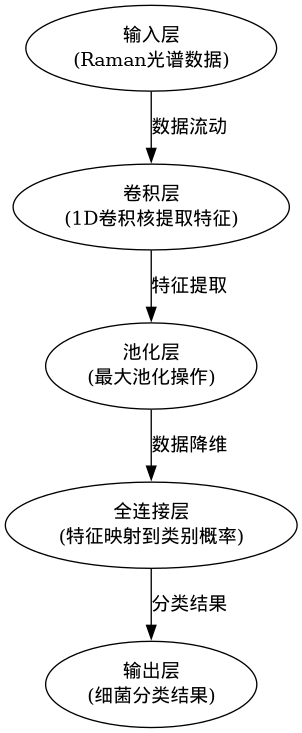

In [1]:
from graphviz import Digraph

# 创建图对象
dot = Digraph(comment='CNN模型流程图')

# 添加节点
dot.node('A', '输入层\n(Raman光谱数据)')
dot.node('B', '卷积层\n(1D卷积核提取特征)')
dot.node('C', '池化层\n(最大池化操作)')
dot.node('D', '全连接层\n(特征映射到类别概率)')
dot.node('E', '输出层\n(细菌分类结果)')

# 添加边 (箭头)
dot.edge('A', 'B', label='数据流动')
dot.edge('B', 'C', label='特征提取')
dot.edge('C', 'D', label='数据降维')
dot.edge('D', 'E', label='分类结果')

# 渲染并输出流程图
dot.render('cnn_flowchart', format='png', cleanup=True)


# 显示流程图（如果在Jupyter Notebook中）
from IPython.display import Image
Image(filename='cnn_flowchart.png')

In [1]:
import os 


os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [ ]:
# Load model directly
from transformers import AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1", trust_remote_code=True)

# Trainer debug

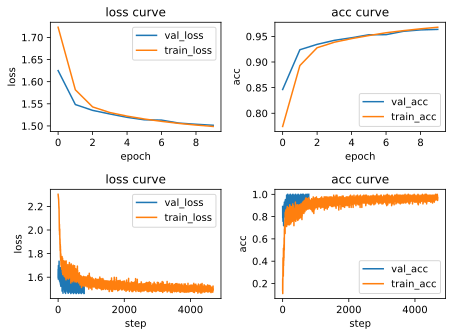

In [1]:
%config InlineBackend.figure_format = 'svg'

import torch 
import torch.nn as nn 
import torchvision
import torch.utils.data as data
from deepspore.training import set_seed, Callback, Trainer


# set seed 
set_seed(seed= 42) 


# 数据准备
dbs = './data/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), ])

train_dataset = torchvision.datasets.MNIST(root= dbs, train= True, download= True, transform= transforms)
test_dataset = torchvision.datasets.MNIST(root= dbs, train= False, download= True, transform= transforms)
## 迭代型数据方式
train_iter = data.DataLoader(dataset= train_dataset, batch_size= 128, shuffle= True)    # train需要shuffle
test_iter = data.DataLoader(dataset= test_dataset, batch_size= 128)                     # test不需要shuffle训练


# 网络结构
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1024), nn.ReLU(),
            nn.Linear(1024, 10), nn.Softmax()
        )

    def forward(self, X):
        return self.network(X)


# Trainer
## callback
class PrintCallback(Callback):
    def on_train_begin(self, **kwargs):
        print("Runing on train begin ...")

# lr 0.01 -> 0.5
net = Net()  
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params= net.parameters(), lr=0.5)   

trainer = Trainer(
    device= 'auto', 
    train_dataloader= train_iter, 
    val_dataloader= test_iter, 
    model= net, 
    loss_fn= loss_fn, 
    optimizer= opt, 
    is_tqdm= False, 
    callbacks= [PrintCallback(), ]
)

trainer.train(epochs= 10)

# trainer.metrics_tracker._history
# trainer.metrics_tracker.get_history()
# trainer.save_metrics(file_path= "./cache/metrics_tracker_history.pickle")
# trainer.save_checkpoint(file_path= './cache/checkpoint.pt')
# trainer.load_checkpoint(file_path= './cache/checkpoint.pt')

In [3]:
import torch 


x = torch.normal(
    mean= 15, 
    std= 2, 
    size= (50, )
)

x

tensor([17.4783, 17.0689, 16.0402, 18.3366, 17.3741, 15.4922, 17.1977, 10.9761,
        18.4936, 14.0914, 13.3737, 13.8254, 11.0262, 16.2682, 19.1848, 12.9575,
        12.8160, 14.7001, 14.5519, 16.5091, 16.7092, 13.2201, 17.5773, 16.3119,
        20.6186, 13.6724, 16.1867, 18.0190, 13.6445, 15.5848, 17.9478, 16.4390,
        15.5210, 17.0769, 12.8182, 17.3689, 17.0333, 10.2943, 13.8676, 14.6377,
        14.6991, 12.2929, 13.8298, 15.4749, 15.0542, 18.0824, 12.6521, 13.3826,
        14.9734, 17.6252])

# papers

开始分析关键词: ("deep learning"[tiab] OR "machine learning"[tiab] OR "artificial intelligence"[tiab] OR "AI"[tiab]) 
找到 1000 篇文献


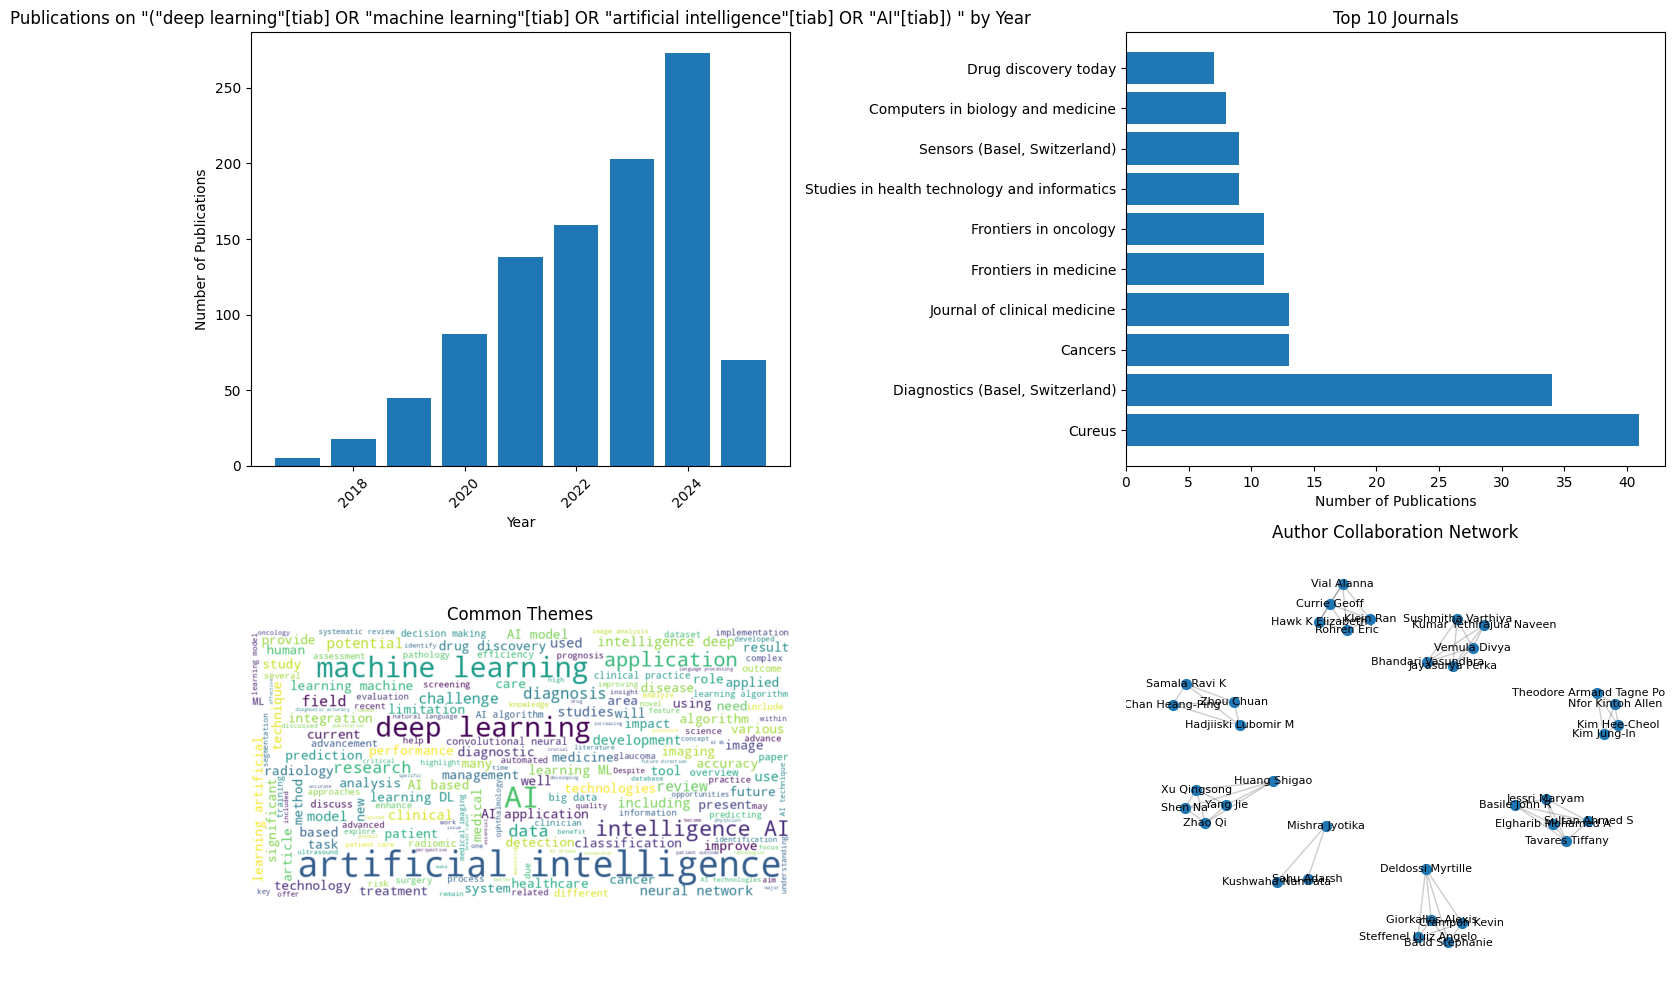


主题模型分析结果:
主题 #1: myopia, veterinary, endodontics, brachytherapy, cov, sars, sc, shoulder, elbow, cerebral
主题 #2: learning, data, clinical, applications, deep, machine, research, imaging, review, ml
主题 #3: crc, wound, sports, nanomedicine, biophysical, microfluidic, orthopaedic, length, dependency, nanoscale
主题 #4: transplant, anesthesia, ra, radiosurgery, anticancer, kt, pv, cadd, pocus, stereotactic
主题 #5: copd, stress, sleep, otorhinolaryngology, livestock, cdss, plant, stresses, biotic, abiotic

分析摘要:
时间范围: 2017-2025
总文献数: 998
涉及期刊数: 578
涉及作者数: 5083
最高产期刊: Cureus (41篇)


In [14]:
from deepspore.pubmed import pubmed_analysis


keywords = '''("deep learning"[tiab] OR "machine learning"[tiab] OR "artificial intelligence"[tiab] OR "AI"[tiab]) '''
pubmed_analysis.analysis(
    email= 'zhao_sy@126.com', 
    keyword= terms, 
    max_results= 1000
)
# help(pubmed_analysis.analysis)

In [2]:
from deepspore.pubmed import entrze_tools


pubmed = entrze_tools.NCBI()

In [ ]:
# Example usage
terms = '''("deep learning"[tiab] OR "machine learning"[tiab] OR "artificial intelligence"[tiab] OR "AI"[tiab])'''

pubmed.get_tiab(terms= terms, retmax= 10000, pubmed_records_path= "./cache/pubmed_records.pkl")

In [3]:
papers = pubmed.analysis(records_path= './cache/pubmed_records.pkl')

Analysis record:   0%|          | 0/9973 [00:00<?, ?it/s]

In [4]:
pubmed.visualize(papers= papers)

['2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 

```mermaid
flowchart TD;
    A([raw reads])--"-fastq_mergepairs @"-->B[merged reads] --"-fastq_filter"--> C[filtered reads];
    C[filtered reads] --"-fastx_uniques"--> D[dereplicated reads];
    D --"-cluster_otus"--> OTU[OTU];
    D --"-unoise3"--> ZOTU[ZOTU];
    OTU --> fasta[reference sequences];
    ZOTU --> fasta;
    fasta -. "-otutab/zotutab" .-> feature_table[OTU/ZOTU table];
    B -.-> feature_table;
    feature_table --"-otutab_rare"--> normalized[normalized table];
    fasta --"-sintax"--> taxa[taxa];
```


```mermaid
gantt
    title A Gantt Diagram
    dateFormat YYYY-MM-DD
    section Section
        A task          :a1, 2014-01-01, 30d
        Another task    :after a1, 20d
    section Another
        Task in Another :2014-01-12, 12d
        another task    :24d

```